This notebook takes from the tutorial at https://docs.lsdb.io/en/stable/tutorials/pre_executed/des-gaia.html. I intend to manipulate it as necessary to crossmatch the data used in previous versions of des_gaia_xmatch.ipynb, and perform the data pipeline.

In [1]:
from pathlib import Path

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

from dask.distributed import Client
import dask.array
from dask.dataframe.utils import make_meta

from hats import read_hats
from hats.inspection import plot_pixels
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM

In [2]:
# Change to the directories where the data will be stored
DES_DIR = Path("../../lsdb_tutorials/data/DES_DR2")
GAIA_DIR = Path("../../lsdb_tutorials/data/Gaia_DR3")

GAIA_SCHEMA_FILE = GAIA_DIR / "schema.parquet"

DES_HATS_NAME = "des_dr2"
GAIA_HATS_NAME = "gaia_dr3"
GAIA_MARGIN_CACHE_NAME = "gaia_dr3_1arcsec"
XMATCH_NAME = "des_dr2_x_gaia_dr3"

HATS_DIR = Path("../../lsdb_tutorials/catalogs")
DES_HATS_DIR = HATS_DIR / DES_HATS_NAME
GAIA_HATS_DIR = HATS_DIR / GAIA_HATS_NAME
GAIA_MARGIN_CACHE_DIR = HATS_DIR / GAIA_MARGIN_CACHE_NAME

XMATCH_DIR = HATS_DIR / XMATCH_NAME

In [3]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 1
collinear_error_cutoff = 0.2
pm_speed_min = 2000 #units are milliseconds per year
pm_speed_max = 10**5
cone_search_rad = 50
max_neighbor_dist = 18
milliarc_degree_conversion = 1/(1000*3600)

In [4]:
des_catalog = lsdb.read_hats(DES_HATS_DIR)
gaia_catalog = lsdb.read_hats(GAIA_HATS_DIR)
xmatch_catalog = lsdb.read_hats(XMATCH_DIR)

In [5]:
print(type(xmatch_catalog))
print(type(gaia_catalog))
print(type(des_catalog))

<class 'lsdb.catalog.catalog.Catalog'>
<class 'lsdb.catalog.catalog.Catalog'>
<class 'lsdb.catalog.catalog.Catalog'>


In [6]:
pm_filter_xmatch = xmatch_catalog.query(f'{pm_speed_max**2} >(pmra_gaia**2 + pmdec_gaia**2) > {pm_speed_min**2}')
with Client():
    df = pm_filter_xmatch.compute()

df

,COADD_OBJECT_ID_des,TILENAME_des,HPIX_32_des,HPIX_64_des,HPIX_1024_des,HPIX_4096_des,HPIX_16384_des,RA_des,DEC_des,ALPHAWIN_J2000_des,DELTAWIN_J2000_des,GALACTIC_L_des,GALACTIC_B_des,XWIN_IMAGE_des,YWIN_IMAGE_des,A_IMAGE_des,ERRA_IMAGE_des,B_IMAGE_des,ERRB_IMAGE_des,THETA_J2000_des,ERRTHETA_IMAGE_des,KRON_RADIUS_des,EBV_SFD98_des,MAG_AUTO_G_DERED_des,MAG_AUTO_R_DERED_des,MAG_AUTO_I_DERED_des,MAG_AUTO_Z_DERED_des,MAG_AUTO_Y_DERED_des,WAVG_MAG_PSF_G_DERED_des,WAVG_MAG_PSF_R_DERED_des,WAVG_MAG_PSF_I_DERED_des,WAVG_MAG_PSF_Z_DERED_des,WAVG_MAG_PSF_Y_DERED_des,EXTENDED_CLASS_COADD_des,EXTENDED_CLASS_WAVG_des,FLAGS_G_des,IMAFLAGS_ISO_G_des,NEPOCHS_G_des,FLAGS_R_des,IMAFLAGS_ISO_R_des,NEPOCHS_R_des,FLAGS_I_des,IMAFLAGS_ISO_I_des,NEPOCHS_I_des,FLAGS_Z_des,IMAFLAGS_ISO_Z_des,NEPOCHS_Z_des,FLAGS_Y_des,IMAFLAGS_ISO_Y_des,NEPOCHS_Y_des,XWIN_IMAGE_G_des,XWIN_IMAGE_R_des,XWIN_IMAGE_I_des,XWIN_IMAGE_Z_des,XWIN_IMAGE_Y_des,YWIN_IMAGE_G_des,YWIN_IMAGE_R_des,YWIN_IMAGE_I_des,YWIN_IMAGE_Z_des,YWIN_IMAGE_Y_des,X2WIN_IMAGE_G_des,X2WIN_IMAGE_R_des,X2WIN_IMAGE_I_des,X2WIN_IMAGE_Z_des,X2WIN_IMAGE_Y_des,Y2WIN_IMAGE_G_des,Y2WIN_IMAGE_R_des,Y2WIN_IMAGE_I_des,Y2WIN_IMAGE_Z_des,Y2WIN_IMAGE_Y_des,XYWIN_IMAGE_G_des,XYWIN_IMAGE_R_des,XYWIN_IMAGE_I_des,XYWIN_IMAGE_Z_des,XYWIN_IMAGE_Y_des,ERRX2WIN_IMAGE_G_des,ERRX2WIN_IMAGE_R_des,ERRX2WIN_IMAGE_I_des,ERRX2WIN_IMAGE_Z_des,ERRX2WIN_IMAGE_Y_des,ERRY2WIN_IMAGE_G_des,ERRY2WIN_IMAGE_R_des,ERRY2WIN_IMAGE_I_des,ERRY2WIN_IMAGE_Z_des,ERRY2WIN_IMAGE_Y_des,ERRXYWIN_IMAGE_G_des,ERRXYWIN_IMAGE_R_des,ERRXYWIN_IMAGE_I_des,ERRXYWIN_IMAGE_Z_des,ERRXYWIN_IMAGE_Y_des,AWIN_IMAGE_G_des,AWIN_IMAGE_R_des,AWIN_IMAGE_I_des,AWIN_IMAGE_Z_des,AWIN_IMAGE_Y_des,BWIN_IMAGE_G_des,BWIN_IMAGE_R_des,BWIN_IMAGE_I_des,BWIN_IMAGE_Z_des,BWIN_IMAGE_Y_des,THETAWIN_IMAGE_G_des,THETAWIN_IMAGE_R_des,THETAWIN_IMAGE_I_des,THETAWIN_IMAGE_Z_des,THETAWIN_IMAGE_Y_des,ERRAWIN_IMAGE_G_des,ERRAWIN_IMAGE_R_des,ERRAWIN_IMAGE_I_des,ERRAWIN_IMAGE_Z_des,ERRAWIN_IMAGE_Y_des,ERRBWIN_IMAGE_G_des,ERRBWIN_IMAGE_R_des,ERRBWIN_IMAGE_I_des,ERRBWIN_IMAGE_Z_des,ERRBWIN_IMAGE_Y_des,ERRTHETAWIN_IMAGE_G_des,ERRTHETAWIN_IMAGE_R_des,ERRTHETAWIN_IMAGE_I_des,ERRTHETAWIN_IMAGE_Z_des,ERRTHETAWIN_IMAGE_Y_des,FLUX_RADIUS_G_des,FLUX_RADIUS_R_des,FLUX_RADIUS_I_des,FLUX_RADIUS_Z_des,FLUX_RADIUS_Y_des,FWHM_IMAGE_G_des,FWHM_IMAGE_R_des,FWHM_IMAGE_I_des,FWHM_IMAGE_Z_des,FWHM_IMAGE_Y_des,ISOAREA_IMAGE_G_des,ISOAREA_IMAGE_R_des,ISOAREA_IMAGE_I_des,ISOAREA_IMAGE_Z_des,ISOAREA_IMAGE_Y_des,BACKGROUND_G_des,BACKGROUND_R_des,BACKGROUND_I_des,BACKGROUND_Z_des,BACKGROUND_Y_des,NITER_MODEL_G_des,NITER_MODEL_R_des,NITER_MODEL_I_des,NITER_MODEL_Z_des,NITER_MODEL_Y_des,KRON_RADIUS_G_des,KRON_RADIUS_R_des,KRON_RADIUS_I_des,KRON_RADIUS_Z_des,KRON_RADIUS_Y_des,MAG_AUTO_G_des,MAG_AUTO_R_des,MAG_AUTO_I_des,MAG_AUTO_Z_des,MAG_AUTO_Y_des,MAGERR_AUTO_G_des,MAGERR_AUTO_R_des,MAGERR_AUTO_I_des,MAGERR_AUTO_Z_des,MAGERR_AUTO_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,FLUX_AUTO_G_des,FLUX_AUTO_R_des,FLUX_AUTO_I_des,FLUX_AUTO_Z_des,FLUX_AUTO_Y_des,FLUXERR_AUTO_G_des,FLUXERR_AUTO_R_des,FLUXERR_AUTO_I_des,FLUXERR_AUTO_Z_des,FLUXERR_AUTO_Y_des,WAVG_FLUX_PSF_G_des,WAVG_FLUX_PSF_R_des,WAVG_FLUX_PSF_I_des,WAVG_FLUX_PSF_Z_des,WAVG_FLUX_PSF_Y_des,WAVG_FLUXERR_PSF_G_des,WAVG_FLUXERR_PSF_R_des,WAVG_FLUXERR_PSF_I_des,WAVG_FLUXERR_PSF_Z_des,WAVG_FLUXERR_PSF_Y_des,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_SPREAD_MODEL_G_des,WAVG_SPREAD_MODEL_R_des,WAVG_SPREAD_MODEL_I_des,WAVG_SPREAD_MODEL_Z_des,WAVG_SPREAD_MODEL_Y_des,SPREADERR_MODEL_G_des,SPREADERR_MODEL_R_des,SPREADERR_MODEL_I_des,SPREADERR_MODEL_Z_des,SPREADERR_MODEL_Y_des,WAVG_SPREADERR_MODEL_G_des,WAVG_SPREADERR_MODEL_R_des,WAVG_SPREADERR_MODEL_I_des,WAVG_SPREADERR_MODEL_Z

In [7]:
print(type(df))

<class 'nested_pandas.nestedframe.core.NestedFrame'>


In [ ]:
df_no_dupes = df[~df['source_id_gaia'].duplicated(keep='first')]

df_no_dupes

# For some reason this step results in the df having no columns, leading to errors further down the line.
# Since we are currently working with a empty df, I will skip performing this step for now.

""
_healpix_29


In [50]:
gaia_ids = df_no_dupes['source_id_gaia']

#dropping because otherwise produces error when performing .apply below
df_no_dupes = df_no_dupes.drop('source_id_gaia_gaia', axis=1)

df_no_dupes

KeyError: "Column 'source_id_gaia' not found in nested columns or base columns"

/Users/joaopassos/Software/HPMS_search/venv/lib/python3.11/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.
  warnings.warn(
/Users/joaopassos/Software/HPMS_search/venv/lib/python3.11/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting double[pyarrow] to object dtype.
  warnings.warn(


Text(0.5, 1.0, 'Absolute magnitude — color diagram')

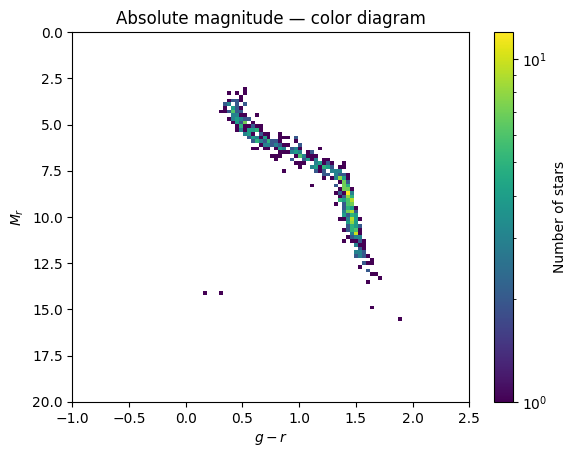

In [11]:
# Read the cross-matched catalog, just like we did before for Gaia and DES,
# but keeping few columns only.
xmatched_from_disk = lsdb.read_hats(
    XMATCH_DIR,
    columns=[
        "parallax_gaia",
        "parallax_over_error_gaia",
        "WAVG_MAG_PSF_G_des",
        "WAVG_MAG_PSF_R_des",
    ],
)

# Apply quality flags
filtered = xmatched.query(
    "parallax_over_error_gaia > 10.0 and WAVG_MAG_PSF_G_des > 0.0 and WAVG_MAG_PSF_R_des > 0.0"
)

# Get Dask data frame from the catalog object
ddf = filtered._ddf

# get 2D histogram of WAVG_MAG_PSF_R-WAVG_MAG_PSF_I vs WAVG_MAG_PSF_I, lazily
color = ddf["WAVG_MAG_PSF_G_des"] - ddf["WAVG_MAG_PSF_R_des"]
absolute_r = ddf["WAVG_MAG_PSF_R_des"] + 5 * np.log10(ddf["parallax_gaia"] / 100)

x_bins = np.linspace(-1, 2.5, 101)
y_bins = np.linspace(0, 20, 101)

hist2d = dask.array.histogram2d(color.to_dask_array(), absolute_r.to_dask_array(), bins=[x_bins, y_bins])

# Run the computation with Dask client, it will take a while
hist2d = hist2d[0].compute()

# Plot the 2D histogram
plt.imshow(
    hist2d.T,
    extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]),
    aspect="auto",
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.gca().invert_yaxis()
plt.colorbar(label="Number of stars")
plt.xlabel("$g-r$")
plt.ylabel("$M_r$")
plt.title("Absolute magnitude — color diagram")